# Flipping coins with Professor Mittens

## Outline and housekeeping

The material in this notebook covers four topics: binomial distributions, the central limit theorem, outliers in data and invalid model assumptions. _You will have approximately 15 minutes to work through each part, after which we will go through the answers together._ Exercises marked as "extension" may be more challenging, so you can skip them on a first reading if you feel they will take too much time.

This notebook is available on github [here](https://github.com/aezarebski/aas-extended-examples). If you find errors or would like to suggest an improvement, feel free to create an issue.

## Introduction

In this lab we will look at the binomial distribution, central limit theorem, and analyse two data sets collected by [Professor Mittens](https://en.wikipedia.org/wiki/Mittens_(cat)) helping him interrogate the bais in the results of coin flips. Some of the questions are open-ended by design. Partial solutions will be distributed at the end of the session. The imports below are used in the provided solutions, consider these suggestions, not constraints. The answers use `altair` but you can use any plotting library you are comfortable with.

In [1]:
import pandas as pd
from scipy import stats
import altair as alt
from typing import List, Any, Tuple
from functools import reduce
from itertools import repeat
import math as math

## Parameter estimation of the binomial distribution

Bernoulli and binomial random variables are the typical way to represent the outcome of coin flips. Below we consider estimates of the probability of heads based on a known number of successes in a given number of trials and also a confidence interval (CI) for this based on the Wald method will be given.

Let $X$ be a binomial random variable (RV) which results from the number of heads when a coin is flipped $n$ times and the probability of coming up heads is $p$. For the time being we will assume that $n$ is know. The expected value of $X$ is $np$. So a simple way to estimate $p$ is to divide the number of heads, $X$, by the number of flips, $n$. This gives the estimate 

$$
\hat{p} = X / n.
$$

It turns out that this is a very sensible thing to do. The resulting estimate is called the maximum likelihood estimate (MLE) of $p$. It is also the result that one obtains via [the method of moments](https://en.wikipedia.org/wiki/Method_of_moments_(statistics)).

Given an estimator though, we want to know how confident we are in the estimate it produces. Here we will use the Wald method to get the $95\%$ CI. It is a very simple method but is acceptable when we have a fair bit of data. The estimated standard error of $\hat{p}$ is $\sqrt{\hat{p}(1-\hat{p})/n}$, so the Wald CI is given by

$$
\hat{p} \pm z \sqrt{\frac{\hat{p}(1-\hat{p})}{n}}
$$

where $z$ is the appropriate quantile of the standard normal distribution. In the case of a $95\%$ distribution this is just $1.96$.

This is stated on the [wikipedia](https://en.wikipedia.org/wiki/Binomial_distribution#Estimation_of_parameters) but there is also a reasonably clear description in [All of Statistics](https://link.springer.com/book/10.1007/978-0-387-21736-9) which you can get via SOLO. You can also find reasonable treatments of Wald CIs in both of those resources.

### Exercise 1 part I

Professor Mittens is not very familiar with the binomial distribution and wants you to justify the estimator used above. Convince yourself that the estimate given above, $X/n$, is a sensible choice. Prove that it is either the MLE or the method of moments estimator for $p$. State the limitations on the estimator we are using for the CI.

#### Answer

If $n$ number of coin flips result in $\bar{X}$ number of heads, then the probability of getting heads is $n \times p$. It follows from this that $p = \frac{\bar{X}}{n}$

### Exercise 1 part II

Implement a function called `wald_estimate_and_ci` which takes two arguments: `num_trials` which is $n$ in the description above, and `num_success` which is $X$ above. The function should return `(p_hat,(wald_lower,wald_upper))` where `p_hat` is $\hat{p}$ and `wald_x` are the limits on the $95\%$ CI using the Wald method.

In [4]:
import numpy as np

def wald_estimate_and_ci(num_trials, num_success):
    p_hat = num_success/num_trials
    wald_estimate_se = np.sqrt((p_hat * (1 - p_hat)) / num_trials)
    wald_lower = p_hat - 1.96 * wald_estimate_se
    wald_upper = p_hat + 1.96 * wald_estimate_se
    return((p_hat,(wald_lower,wald_upper)))

In [5]:
wald_estimate_and_ci(100, 50)

(0.5, (0.402, 0.598))

### Exercise 2 part I

Look up how to simulate a random variable from a binomial distribution (it tells you [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom.html#scipy.stats.binom) if you want to use `scipy`). Then simulate a binomial random variable with $n=100$ and $p=0.6$. Then use the value and the `wald_estimate_and_ci` function to see how well you can estimate $p$. Write a couple of sentences to explain this.

### Exercise 2 part II

Repeat the process about 100000 times and see what proportion of the CIs capture the true value of $p$. Is it what you expect? Write a couple of sentences to explain what you found.

In [7]:
#### Answer - Ex 2 pt 

rand_xs = stats.binom.rvs(n=100, p=0.6, size = 100000)


### Exercise 2 part III

Are credible intervals and confidence intervals the same thing?

## Central limit theorem

The central limit theorem tells us about the limiting distribution of the sample mean for distribution for an IID sample with a finite variance. It underpins many results in statistics and is important for reasoning about stochastic processes.

### Exercise 3 part I (Extension)

Professor Mittens *really* likes to sound fancy and use the name of important theorems. Write down a statement of the law of large numbers. Write down a statement of the central limit theorem. Make sure you understand what each of them tells you.

#### Answer
##### Law of large numbers
As the number of observations $n$ increases, so does the certainty of claims we can make
##### Central limit theorem
As the number of observations $n$ moves towards infinity, the distribution of the sample means starts to approach a gaussian distribution. 

### Exercise 3 part II

To see that the distribution of the sample mean converges to a normal distribution we will do a simulation study and compare the results with a Q-Q plot to see if it looks normally distributed. This will also demonstrate how to construct a Q-Q plot from first principles, not that you really want to do that. Carry out the following steps:

1. Write down the distribution of the sample mean given an IID sample of exponential random variables with rate $1/5$.
2. Generate 500 sample means each based on a sample of 100 exponential random variables
3. Make a visualisation of the distribution of the data (e.g., a KDE or histogram) and overlay the CLT approximation.
4. Make a Q-Q plot to see if the sample means do appear to follow a normal distribution

In [21]:
sample_size = 100
num_replicates = 500

sample_means = [stats.expon.rvs(scale = 5, size = sample_size).mean() for _ in range(num_replicates)]

plot_df = pd.DataFrame({"sample_mean": sample_means})

mesh_size = 200
x_vals = [0.02 * ix + 3 for ix in range(0,mesh_size)]

clt_scale = 5 / math.sqrt(sample_size)

clt_pdf = [stats.norm.pdf(x, loc = 5, scale = clt_scale) for x in x_vals]
clt_df = pd.DataFrame({"x": x_vals, "pdf": clt_pdf})

In [22]:
data_kde = (alt
                .Chart(plot_df)
                .transform_density(
                    'sample_mean',
                    as_=['sample_mean', 'density'],
                    extent=[3,7]
                )
                .mark_area()
                .encode(x = alt.X("sample_mean:Q",
                                 title="Sample mean"),
                        y = "density:Q"))

clt_line = (alt
               .Chart(clt_df)
               .mark_line(color = "red")
               .encode(x = "x",
                       y = "pdf"))

data_kde + clt_line

alt.LayerChart(...)

In [23]:
unit_mesh = [1 - (1 / len(sample_means)) * ix - (0.5 / len(sample_means)) for ix in range(0,len(sample_means))]
quantile_vals = [stats.norm.isf(u, loc = 5, scale = clt_scale) for u in unit_mesh]
sample_means.sort()
quant_df = pd.DataFrame({
    "sample_means": sample_means,
    "quantiles": quantile_vals})

ab_lims = [min(sample_means)-0.1, max(sample_means)+0.1]
abline_df = pd.DataFrame({"x": ab_lims, "y": ab_lims})

quant_points = (alt
                   .Chart(quant_df)
                   .mark_point()
                   .encode(x =  alt.X('sample_means:Q',
                                      scale=alt.Scale(zero=False),
                                      title = "Sample mean quantile"),
                           y = alt.Y('quantiles:Q',
                                      scale=alt.Scale(zero=False),
                                      title = "Normal quantile")))

ab_line = (alt
          .Chart(abline_df)
          .mark_line(color = "red")
          .encode(x = "x", y = "y"))

quant_points + ab_line

alt.LayerChart(...)

## Experimental results: flipping coins in series

Professor Mittens asked 15 of his students to each take turns flipping a coin 30 times and recording how many heads they got. He has a sneaking suspicion that some of the students did not actually do this properly, that they just wrote down some garbage and went to lunch early. We will help Mittens work out whether the coin that was used was fair, i.e. has an equal chance of showing heads or tails.

### Exercise 3 part I

Read the data in `experiement1.csv` into a `DataFrame`. Use some of the commands you've seen in lectures to inspect the data, noting that it may not be in the optimal format for analysis.

In [24]:
df = pd.read_csv('experiment1.csv')

In [68]:
df.head()
sample_means = df.groupby(by =['name']).mean()
sample_counts = df.groupby(by =['name']).sum()
sample_means = sample_means.drop(['flip_number'], axis = 1)

### Exercise 3 part II

Compute the point estimate and CI using the function you wrote above. Write a sentence explaining whether you think the coin is a _fair_ coin given the results you have just obtained.

In [55]:
heads = len(df[df['outcome'] == 1]['outcome'])
total = len(df)

# Do not think it's a fair coin given that probability differs substantially between students

In [56]:
wald_estimate_and_ci(total, heads)

(0.49333333333333335, (0.44713979693549655, 0.5395268697311701))

### Exercise 3 part III

Generate a histogram of the number of heads from each student. As an extension, include the binomial distribution supported by your estimate that is most amenable to large value outcomes.

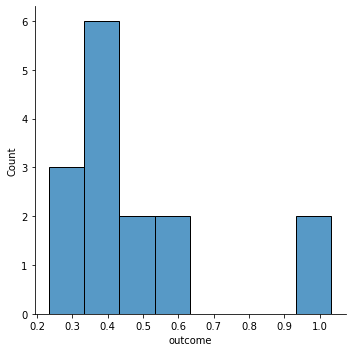

In [64]:
import seaborn as sns

sns.displot(sample_means, x='outcome', binwidth=0.1)

### Exercise 4 part I

It looks like there might be a couple of strange points in this dataset as Mittens suspected. Using the upper bound on $p$ calculate the probability of someone getting all heads. Write a couple of sentences explaining whether you think it is reasonable to remove those data points.

In [65]:
stats.binom.pmf(k=30, n=30, p=0.54)

9.371579521404065e-09

### Exercise 4 part II

Remove the outliers and repeat the process of plotting the data and estimating the parameters and CI. Once you have done this, plot the distribution of the estimated binomial distribution on top of the histogram. Write a couple of sentences explaining what you think about the coin now.

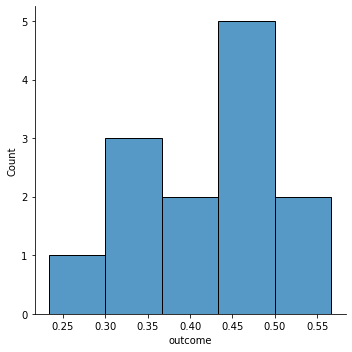

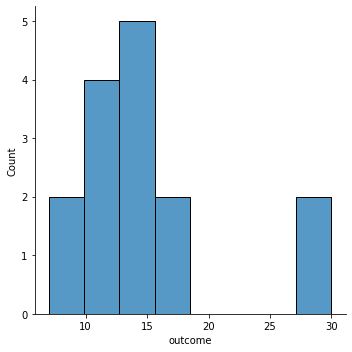

In [69]:
sample_means_cleaned = sample_means[sample_means['outcome'] < 1]
sns.displot(sample_means_cleaned, x='outcome')

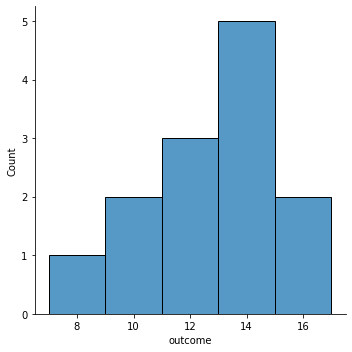

In [70]:
sample_counts_cleaned = sample_counts[sample_counts['outcome'] < 30]
sns.displot(sample_counts_cleaned, x='outcome')


## Experimental results: flipping coins in parallel

After the success of his first experiment, Mittens was lauded as a statistical wizard. The royal mint has become interested and is providing additional funds to obtain an additional 49 coins and repeat the experiment to gather more data about the fascinating topic of coin bias. Now he gives each of 50 students a coin each and asks them to flip the coin 30 times and record the results. We will help Mittens work out whether the coins are fair.

### Excercise 5 part I

Do we need to change anything about how we analyse this data? If so, why, if not, why not? **Hint:** there are good arguments that can be given for each answer. Once you have answered one way, try to answer the other way. 

##### Answer 
We saw in the last exercise that one of the students was consistently cheating the exercise. Alternatively, if we assume that the students don't cheat we can reeat in the same way

### Exercise 5 part II

Using the data in `experiment2.csv` explore the data set using the methodology devised above and write a couple of sentences to explain what you found.

In [71]:
df = pd.read_csv('experiment2.csv')

In [75]:
df.head()
sample_means = df.groupby(by =['name']).mean()
sample_counts = df.groupby(by =['name']).sum()
sample_means = sample_means.drop(['flip_number'], axis = 1)
sample_counts = sample_counts.drop(['flip_number'], axis = 1)

print(sample_means)
print(sample_counts)

       outcome
name          
0     0.233333
1     0.233333
2     0.133333
3     0.233333
4     0.133333
5     0.133333
6     0.333333
7     0.233333
8     0.366667
9     0.100000
10    0.400000
11    0.333333
12    0.400000
13    0.400000
14    0.300000
15    0.466667
16    0.300000
17    0.200000
18    0.300000
19    0.333333
20    0.433333
21    0.500000
22    0.333333
23    0.500000
24    0.400000
25    0.433333
26    0.500000
27    0.500000
28    0.266667
29    0.300000
30    0.433333
31    0.366667
32    0.433333
33    0.433333
34    0.633333
35    0.533333
36    0.666667
37    0.533333
38    0.566667
39    0.366667
40    0.566667
41    0.366667
42    0.533333
43    0.500000
44    0.500000
45    0.600000
46    0.500000
47    0.533333
48    0.600000
49    0.666667
      outcome
name         
0           7
1           7
2           4
3           7
4           4
5           4
6          10
7           7
8          11
9           3
10         12
11         10
12         12
13        

### Exercise 5 part III

Visualise the number of heads each student got and compare the variance in this to what is predicted by theory. Revise your answer to part I of this exercise.

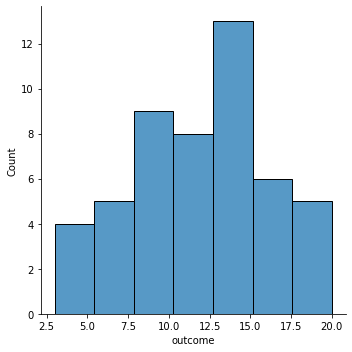

In [77]:
sns.displot(sample_counts, x='outcome')

In [82]:
stats.t.interval(0.95, 49, loc=15)


(12.990424765510792, 17.00957523448921)

### Exercise 5 part IV (Extension)

Consider how you might analyse this data. Over the following weeks you will learn a couple of approaches.

## Epilogue

Professor Mittens' work was published in a top tier journal and he was lauded as a statistical wizard. Rumour has it he will soon be elected to the British Acadmey.